# LSTM

In [2]:
# utility
import numpy as np 
import pandas as pd 
import string
import re

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# model 
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional
import keras
from keras.utils.np_utils import to_categorical

#nltk and sklearn
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# File path
import os
import os.path
from os import path

# Translator
# import googletrans
# from googletrans import Translator

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

### Data

In [3]:
# original english file
filename  = 'Eng-Hin-data/hindi-anot-shuffled'
orig_df = pd.read_csv(filename + '.csv',  
               delimiter=',')
orig_df.columns = ['Text', 'Label']

In [4]:
orig_df["Text"] = orig_df["Text"].astype(str)
orig_df["Label"] = orig_df["Label"].astype(str)
data = orig_df

In [5]:
# Displaying eg tweet
orig_df.Text[6]

"'आज के दिन ही मेरा क्रिकेट प्रेम भी समाप्त हो गया"

In [6]:
sentiment =  data['Label'].values

In [7]:
data.groupby('Label').describe()

Text                                                               
      count unique                                                top freq
Label                                                                     
0      3244   3243  #AllahDoesNotNeedQurbani कबीर परमात्मा ने कहा ...    2
1      2174   2174  'आलम-ए-इस्लाम को इस्लामिक साल मुबारक हो  #हिजर...    1
2      3375   3373                                                  0    3

Text(0.5, 1.0, 'Number of Tweets')

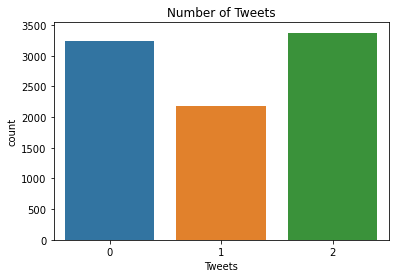

In [8]:
sns.countplot(data.Label)
plt.xlabel('Tweets')
plt.title('Number of Tweets')

### Data Preprocessing

In [17]:
def clean_text(text):
    text = text.lower()
    
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    text = text.lower()
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [18]:
stopword=open("Devanagari/stopwords.txt","r")
stop_words=[]
# pre-process stopword
for i in stopword:
    i = re.sub('[\n]', '', i)
    stop_words.append(i)
hin_stopwords = set(stop_words) 

In [21]:
def CleanTokenize(df):
    tweets = list()
    lines = data["Text"].values.tolist()
    
    for line in lines:
        if isinstance(line, str):
            line = clean_text(line)
        else:
            continue      
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove stop words
        words = [w for w in stripped if not w in hin_stopwords]
        tweets.append(words)
    return tweets

def Tokenize(df):
    tweets = list()
    lines = data["Text"].values.tolist()
    
    for line in lines:
        if isinstance(line, str):
            # tokenize the text
            tokens = word_tokenize(line)
        else:
            continue

        tweets.append(tokens)
    return tweets

tweets = CleanTokenize(data)


(-0.5, 499.5, 299.5, -0.5)

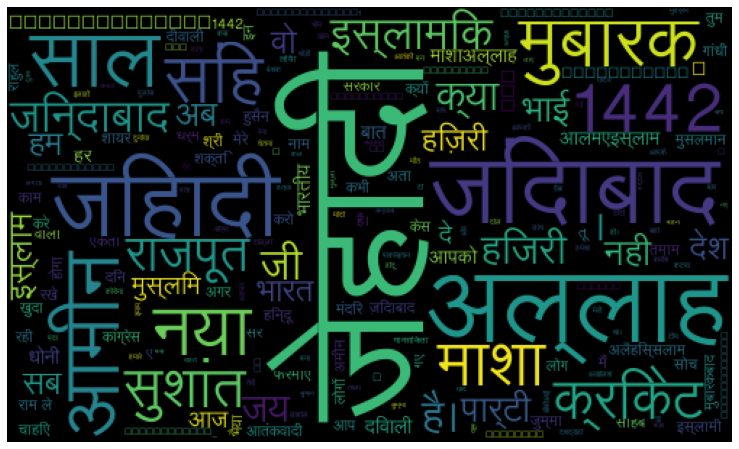

In [25]:
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from wordcloud import WordCloud, ImageColorGenerator


pos_data = data.loc[data['Label'] == 1]
pos_head_lines = Tokenize(pos_data)
#pos_head_lines = tweets
pos_lines = [j for sub in pos_head_lines for j in sub] 
pos_lines = [clean_text(w) for w in pos_lines if not w in hin_stopwords]
word_could_dict=Counter(pos_lines)
# text = ''
# for m in pos_lines:
#     text = text + m + ' '

wordcloud = WordCloud(font_path='Devanagari/Lohit-Devanagari.ttf',width = 500, height = 300, stopwords = hin_stopwords).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

### Splitting data

In [49]:
validation_split = 0.1
max_length = 128


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(tweets)
sequences = tokenizer_obj.texts_to_sequences(tweets)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['Label'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

le = LabelEncoder()
sentiment = le.fit_transform(sentiment)
# transfor from a array to a vector
sentiment = sentiment.reshape(-1,1)


num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]

X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


unique tokens -  18883
vocab size - 18884


In [50]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (7914, 128)
Shape of y_train: (7914, 3)
Shape of X_test_pad: (879, 128)
Shape of y_test: (879, 3)


### Glove from paper DSWI

In [51]:
embeddings_index = {}

# Glove from paper DSWI
f = open('Online_supplement_1 word vectors.csv', encoding='latin1')
count = 0
for line in f:
    if count == 0:
        count = 1
        line = 0
    else:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))



Found 1181930 word vectors.


In [52]:
embedding_dim = 50

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector

In [53]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

## LSTM Model

In [54]:
def createModel(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(512, dropout=0.2, recurrent_dropout=0.50))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.RMSprop(learning_rate=1e-3), metrics=['acc'])
    return model

model = createModel(embedding_layer)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 50)           944200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               1153024   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 2,098,763
Trainable params: 1,154,563
Non-trainable params: 944,200
_________________________________________________________________


In [55]:
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=3, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/3
248/248 - 197s - loss: 1.0989 - acc: 0.3792 - val_loss: 1.0759 - val_acc: 0.3879
Epoch 2/3
248/248 - 196s - loss: 1.0857 - acc: 0.3768 - val_loss: 1.0791 - val_acc: 0.3879
Epoch 3/3
248/248 - 195s - loss: 1.0842 - acc: 0.3848 - val_loss: 1.0930 - val_acc: 0.3879


In [56]:
results = model.evaluate(X_test_pad, y_test, batch_size=32)

28/28 [==============================] - 5s 177ms/step - loss: 1.0930 - acc: 0.3879


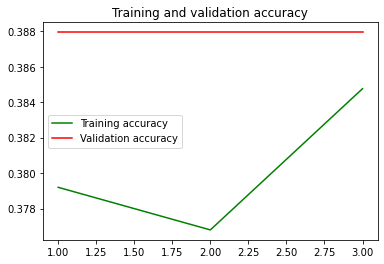

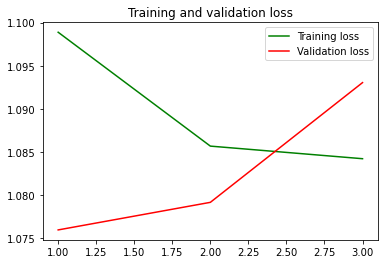

In [57]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 10 Fold cross validation

In [58]:
import random
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import KFold
# KFold cross-validation
kFold = 10
scores = []
validation_split = 0.1
max_length = 25
results = []
train_res = []
print("LSTM with Glove from DSWI: ")
for i in range(kFold):
    print("Fold: ", i+1)
    prediction_val = []
    Y_test = []
    scores=[]
    random_shuff = random.randint(1, 7000)
    X_train_pad, X_test_pad, y_train, y_test = train_test_split(lines_pad, to_categorical(sentiment), test_size=0.10, shuffle = True, random_state=random_shuff)
    model = createModel(embedding_layer)
    history = model.fit(X_train_pad, y_train, batch_size=32, epochs=6, validation_data=(X_test_pad, y_test), verbose=1)
    
    print("Results for current fold:")
    print("Evaluating on train data")
    train_res.append(model.evaluate(X_train_pad, y_train, batch_size=128))
    print("Evaluating on test data")
    results.append(model.evaluate(X_test_pad, y_test, batch_size=128))
    
    y_pred = model.predict(X_test_pad)
    for p in y_pred:
        prediction_val.append(np.argmax(p))
    for t in y_test:
        Y_test.append(np.argmax(t))
    scoreValue = accuracy_score(Y_test,prediction_val)
    scores.append(scoreValue)



LSTM with Glove from DSWI: 
Fold:  1
Epoch 1/6
248/248 [==============================] - 196s 791ms/step - loss: 1.0948 - acc: 0.3787 - val_loss: 1.0885 - val_acc: 0.3716
Epoch 2/6
248/248 [==============================] - 195s 786ms/step - loss: 1.0901 - acc: 0.3867 - val_loss: 1.5882 - val_acc: 0.3716
Epoch 3/6
248/248 [==============================] - 196s 789ms/step - loss: 1.0857 - acc: 0.3863 - val_loss: 1.0793 - val_acc: 0.3716
Epoch 4/6
248/248 [==============================] - 195s 786ms/step - loss: 1.0899 - acc: 0.3810 - val_loss: 1.0835 - val_acc: 0.3716
Epoch 5/6
248/248 [==============================] - 195s 786ms/step - loss: 1.0895 - acc: 0.3713 - val_loss: 1.0802 - val_acc: 0.3716
Epoch 6/6
248/248 [==============================] - 196s 789ms/step - loss: 1.0841 - acc: 0.3771 - val_loss: 1.0794 - val_acc: 0.3716
Results for current fold:
Evaluating on train data
62/62 [==============================] - 32s 519ms/step - loss: 1.0813 - acc: 0.3852
Evaluating on tes

In [59]:
import statistics 

score = []
for i in results:
    score.append(i[1])
x = statistics.mean(score)
    
print("Kfold Mean: ", x)

Kfold Mean:  0.3762499988079071


### Confusion matrix

In [60]:
results2 = confusion_matrix(Y_test,prediction_val)
print ('Confusion Matrix :')
print(results2) 
print ('Accuracy Score :',accuracy_score(Y_test,prediction_val))
print ('Report : ')
print (classification_report(Y_test,prediction_val))

Confusion Matrix :
[[  0   0 309]
 [  0   0 233]
 [  0   0 338]]
Accuracy Score : 0.3840909090909091
Report : 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       309
           1       0.00      0.00      0.00       233
           2       0.38      1.00      0.56       338

    accuracy                           0.38       880
   macro avg       0.13      0.33      0.19       880
weighted avg       0.15      0.38      0.21       880



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
